In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Cleaning**

In [5]:
df = pd.read_csv('synthetic_data.csv')

# Check for missing values
df.isnull().sum()

x         0
y         0
z         0
status    0
dtype: int64

In [6]:
# Remove duplicates
df.drop_duplicates()

,x,y,z,status
0,-0.152375,-0.898320,-0.371662,idle
1,-0.133481,-0.877780,-0.385113,idle
2,-0.121285,-0.909976,-0.381254,idle
3,-0.127859,-0.899945,-0.426131,idle
4,-0.131367,-0.919183,-0.425946,idle
...,...,...,...,...
99995,0.683156,0.519731,-0.366067,soft_concrete
99996,0.787088,0.319512,-0.601208,soft_concrete
99997,0.742647,0.382496,-0.581437,soft_concrete
99998,0.627654,0.409057,-0.536827,soft_concrete


In [7]:
idle_data = df[df['status'] == 'idle']
minor_vibration_data = df[df['status'] == 'minor_vibration']
hard_concrete_data = df[df['status'] == 'hard_concrete']
soft_concrete_data = df[df['status'] == 'soft_concrete']


**Remove Outliers Using Z-Score**

In [8]:
from scipy.stats import zscore

def remove_outliers_by_zscore(data, columns, threshold=3):
    z_scores = zscore(data[columns])
    return data[(z_scores < threshold).all(axis=1)]

idle_data_cleaned = remove_outliers_by_zscore(idle_data, ['x', 'y', 'z'])
minor_vibration_data_cleaned = remove_outliers_by_zscore(minor_vibration_data, ['x', 'y', 'z'])
hard_concrete_data_cleaned = remove_outliers_by_zscore(hard_concrete_data, ['x', 'y', 'z'])
soft_concrete_data_cleaned = remove_outliers_by_zscore(soft_concrete_data, ['x', 'y', 'z'])


In [9]:
df = pd.concat([
    idle_data_cleaned,
    minor_vibration_data_cleaned,
    hard_concrete_data_cleaned,
    soft_concrete_data_cleaned
])

df.reset_index(drop=True, inplace=True)


**Normalization of Data**

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

In [11]:
df.head()

,x,y,z,status
0,-1.028225,-0.970963,-0.582433,idle
1,-0.989732,-0.938208,-0.619078,idle
2,-0.964883,-0.989552,-0.608566,idle
3,-0.978277,-0.973555,-0.730830,idle
4,-0.985424,-1.004235,-0.730327,idle


**Feature Engineering**

In [12]:
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [13]:
window_size = 10

# Calculate rolling mean, standard deviation, max, and min
df['rolling_mean'] = df['magnitude'].rolling(window=window_size).mean()
df['rolling_std'] = df['magnitude'].rolling(window=window_size).std()
df['rolling_max'] = df['magnitude'].rolling(window=window_size).max()
df['rolling_min'] = df['magnitude'].rolling(window=window_size).min()


In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['status_encoded'] = encoder.fit_transform(df['status'])


**Train Test Split**

In [15]:
from sklearn.model_selection import train_test_split

X = df[['magnitude', 'rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min']]
y = df['status_encoded']

# Handle NaN values generated by rolling operations
X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Model**

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [17]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4961
           1       0.94      0.97      0.95      5005
           2       0.96      0.93      0.95      5022
           3       0.96      0.96      0.96      4928

    accuracy                           0.96     19916
   macro avg       0.96      0.96      0.96     19916
weighted avg       0.96      0.96      0.96     19916

Accuracy: 0.96


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f}")


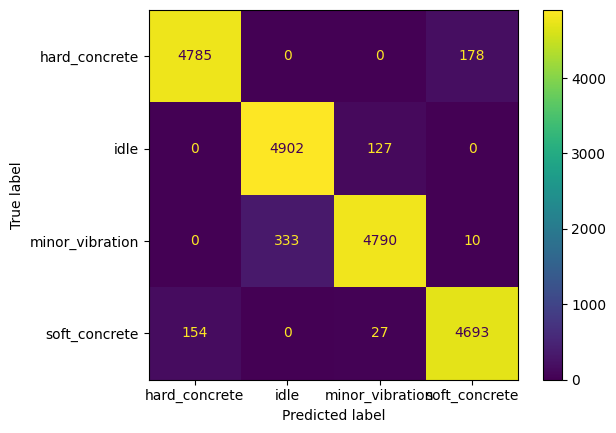

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()


In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=encoder.classes_))


                 precision    recall  f1-score   support

  hard_concrete       0.97      0.96      0.97      4963
           idle       0.94      0.97      0.96      5029
minor_vibration       0.97      0.93      0.95      5133
  soft_concrete       0.96      0.96      0.96      4874

       accuracy                           0.96     19999
      macro avg       0.96      0.96      0.96     19999
   weighted avg       0.96      0.96      0.96     19999



In [ ]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_acc = baseline.score(X_test, y_test)
print(f"Baseline Accuracy: {baseline_acc:.2f}")


Baseline Accuracy: 0.24


**Save Model**

In [19]:
import joblib

joblib.dump(clf, "classification_model.pkl")

['classification_model.pkl']

In [17]:
df.head()

,x,y,z,status,magnitude,rolling_mean,rolling_std,rolling_max,rolling_min,fft,fft_amplitude,status_encoded
0,-1.027891,-0.970761,-0.582901,idle,1.529284,NaN,NaN,NaN,NaN,169747.678415- 0.000000j,169747.678415,1
1,-0.989418,-0.938024,-0.619480,idle,1.497528,NaN,NaN,NaN,NaN,-6390.727148+ 9529.477330j,11473.984994,1
2,-0.964582,-0.989339,-0.608987,idle,1.509992,NaN,NaN,NaN,NaN,99.553973- 7009.586826j,7010.293750,1
3,-0.977969,-0.973351,-0.731030,idle,1.561487,NaN,NaN,NaN,NaN,2141.946018+ 3256.994012j,3898.197370,1
4,-0.985113,-1.004014,-0.730528,idle,1.584980,NaN,NaN,NaN,NaN,24.485652+ 0.708724j,24.495907,1


In [18]:
df.to_csv("test.csv", index=False)

In [265]:
# Group the data by 'status' and calculate the minimum and maximum fft_amplitude
min_max_fft_amplitude = df.groupby('status')['fft_amplitude'].agg(['min', 'max']).reset_index()

# Display the results
print(min_max_fft_amplitude)


            status       min            max
0    hard_concrete  0.547963     276.435759
1             idle  0.790468  158599.190698
2  minor_vibration  0.547963     276.435759
3    soft_concrete  0.790468   10975.059231


In [23]:
np.nan_to_num(df['fft_amplitude'])

array([169747.67841481,  11473.98499436,   7010.29375002, ...,
            0.        ,      0.        ,      0.        ])

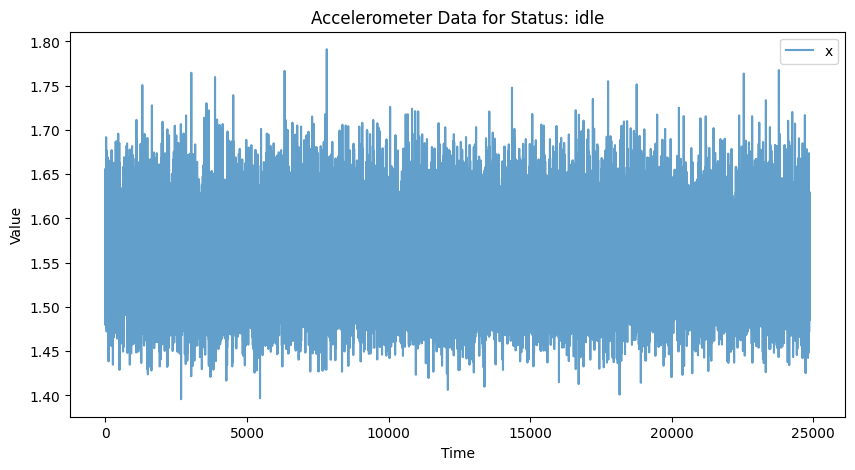

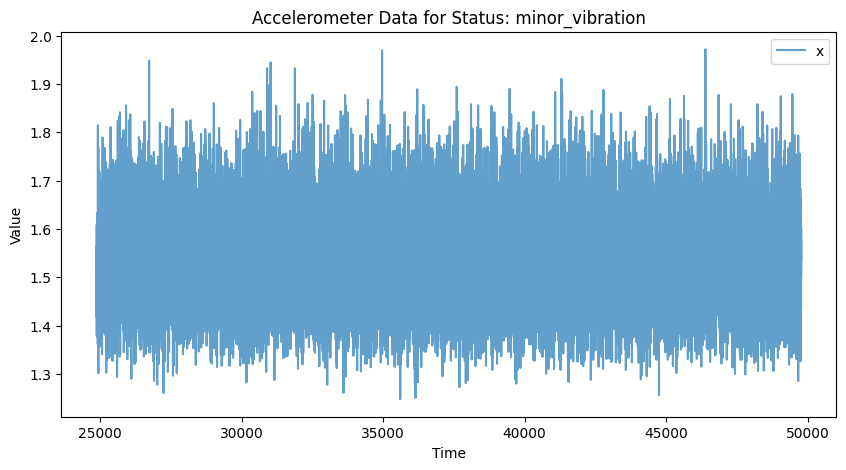

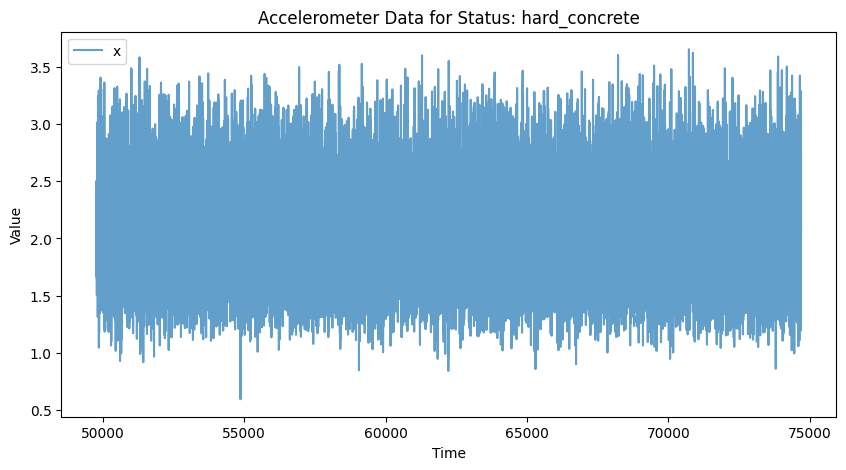

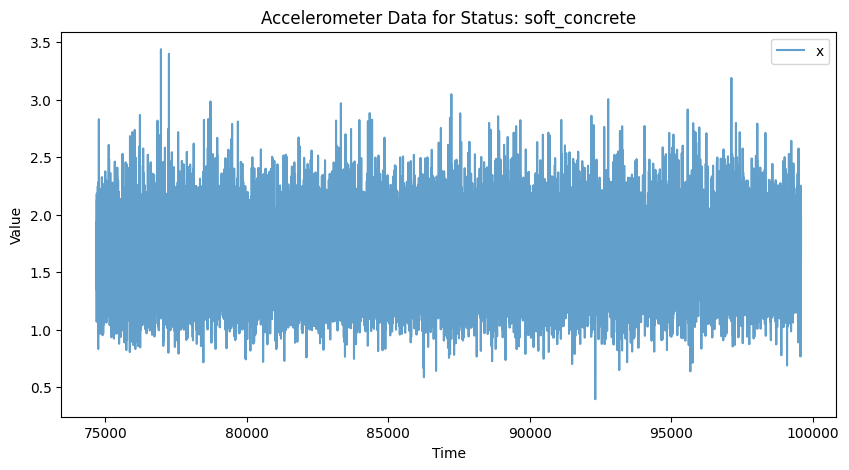

In [18]:
df['time'] = range(len(df))
statuses = df['status'].unique()

for status in statuses:
    subset = df[df['status'] == status]
    plt.figure(figsize=(10, 5))
    plt.plot(subset['time'], subset['magnitude'], label='x', alpha=0.7)
    plt.title(f'Accelerometer Data for Status: {status}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [20]:
df.to_csv("combined_data.csv", index=False)

**Calculate mean and standard deviation of magnitude for each scenarios**

In [22]:
stats = df.groupby('status')['magnitude'].agg(['mean', 'std']).reset_index()
stats.columns = ['status', 'mean_magnitude', 'std_magnitude']

stats

,status,mean_magnitude,std_magnitude
0,hard_concrete,2.059321,0.431418
1,idle,1.557239,0.049052
2,minor_vibration,1.537826,0.093364
3,soft_concrete,1.636227,0.305981
